In [2]:
import os
import pickle
import tsplib95
import csv
import time
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms.approximation.traveling_salesman import *

In [3]:
def get_tsp_graph(name) -> nx.Graph:
    # load from pkl file if exists
    graph_file_path = os.path.join("tsp_dataset", f"{name}.graph.pkl")
    if os.path.exists(graph_file_path):
        # print(f"Loading {name} from pkl {graph_file_path}")
        with open(graph_file_path, "rb") as file:
            G = pickle.load(file)
        return G.to_undirected()

    tsp_file_path = os.path.join("tsp_dataset", f"{name}.tsp")
    # print(f"Loading {name} from tsplib {tsp_file_path}")
    problem = tsplib95.load(tsp_file_path)
    G = problem.get_graph()

    # remove redundant edges
    if problem.edge_weight_type == "EXPLICIT" and problem.edge_weight_format == "FULL_MATRIX":
        for u in G.nodes:
            for v in G.nodes:
                if u > v:
                    G.remove_edge(u, v)

    # remove self loops
    loop_edges = list(nx.selfloop_edges(G))
    G.remove_edges_from(loop_edges)

    # save as pkl file
    with open(graph_file_path, "wb") as file:
        print(f"Saving {name} to pkl {graph_file_path}")
        pickle.dump(G, file)

    return G

In [4]:
tsp_dataset_file_path = os.path.join("tsp_dataset", "tsp_dataset.csv")
print(f"Loading tsp dataset from {tsp_dataset_file_path}")
tsp_dataset = pd.read_csv(tsp_dataset_file_path)

Loading tsp dataset from tsp_dataset\tsp_dataset.csv


In [5]:
def get_opt_tour_length(name):
    return tsp_dataset[tsp_dataset["name"] == name]["opt_tour_length"].values[0]

In [6]:
def get_tour_length(G: nx.graph, tour: list):
    tour_length = 0
    for i in range(len(tour) - 1):
        u, v = tour[i], tour[i + 1]
        w = G[u][v]["weight"]
        tour_length += w
    return tour_length

In [7]:
def get_apx_ratio(G: nx.graph, tour: list):
    return get_tour_length(G, tour) / get_opt_tour_length(G.name)

In [8]:
tsp_dataset

,name,dimension,opt_tour_length,type,comment,edge_weight_type,edge_weight_format
0,burma14,14,3323,TSP,14-Staedte in Burma (Zaw Win),GEO,FUNCTION
1,ulysses16,16,6859,TSP,Odyssey of Ulysses (Groetschel/Padberg),GEO,NaN
2,gr17,17,2085,TSP,17-city problem (Groetschel),EXPLICIT,LOWER_DIAG_ROW
3,gr21,21,2707,TSP,21-city problem (Groetschel),EXPLICIT,LOWER_DIAG_ROW
4,ulysses22,22,7013,TSP,Odyssey of Ulysses (Groetschel/Padberg),GEO,NaN
...,...,...,...,...,...,...,...
91,u2319,2319,234256,TSP,Drilling problem (Reinelt),EUC_2D,NaN
92,pr2392,2392,378032,TSP,2392-city problem (Padberg/Rinaldi),EUC_2D,NaN
93,pcb3038,3038,137694,TSP,Drilling problem (Junger/Reinelt),EUC_2D,NaN
94,fnl4461,4461,182566,TSP,Die 5 neuen Laender Deutschlands (Ex-DDR) (Bac...,EUC_2D,NaN


In [1]:
from mst import MST
st = MST()

In [9]:
def get_total_edge_weight(G: nx.graph):
    total_edge_weight = 0
    for u, v in G.edges:
        total_edge_weight += G[u][v]["weight"]
    return total_edge_weight

In [10]:
from simulated_annealing import SimulateAnnealing

In [11]:
with open("sa_results_berlin52.csv", "a", newline="") as csvfile:
    writer = csv.writer(csvfile)

    for name in tsp_dataset["name"]:
        if name != "berlin52":
            continue
        print(name)
        

        G = get_tsp_graph(name)
        dimension = G.number_of_nodes()
        opt_tour_length = get_opt_tour_length(name)

        d = {
            "name": name,
            "dimension": dimension,
            "opt_tour_length": opt_tour_length,
        }

        best_tour = None
        best_tour_length = None
        best_tour_k = None

        best_sa_tour = None
        best_sa_tour_length = None
        best_sa_tour_k = None
        
        c_tour = None
        c_tour_length = None

        start_time = time.time()

        for k in range(1, 2):
            print(name, k) 
            tree = st.get_mst_k(G, k)
            tour = christofides(G, tree=tree)
            tour_length = get_tour_length(G, tour)
            
            if k == 1:
                c_tour = tour
                c_tour_length = tour_length

            if best_tour is None or tour_length < best_tour_length:
                best_tour = tour
                best_tour_length = tour_length
                best_tour_k = k

            sa = SimulateAnnealing(
                graph=G,
                initial_solution=tour,
                max_iterations=5000,
                initial_temperature=1000,
                cooling_rate=0.01,
            )
            sa_tour, sa_tour_cost = sa.run()
            sa_tour_length = get_tour_length(G, sa_tour)
            assert sa_tour_cost == sa_tour_length

            if best_sa_tour is None or sa_tour_length < best_sa_tour_length:
                best_sa_tour = sa_tour
                best_sa_tour_length = sa_tour_length
                best_sa_tour_k = k

        end_time = time.time()
        elapsed_time = end_time - start_time
        
        c_apx_ratio = c_tour_length / opt_tour_length
        best_apx_ratio = best_tour_length / opt_tour_length
        best_sa_apx_ratio = best_sa_tour_length / opt_tour_length

        d["c_tour_length"] = c_tour_length
        d["best_tour_length"] = best_tour_length
        d["best_sa_tour_length"] = best_sa_tour_length
        d["c_apx_ratio"] = c_apx_ratio
        d["best_apx_ratio"] = best_apx_ratio
        d["best_sa_apx_ratio"] = best_sa_apx_ratio
        d["best_tour_k"] = best_tour_k
        d["best_sa_tour_k"] = best_sa_tour_k
        d["elapsed_time"] = elapsed_time

        print(list(d.values()))
        writer.writerow(d.values())
        csvfile.flush()

        print()

berlin52
berlin52 1
['berlin52', 52, 7542, 8582, 8582, 8582, 1.1378944577035268, 1.1378944577035268, 1.1378944577035268, 1, 1, 0.5130164623260498]



In [12]:
trace = sa.get_trace()

In [13]:
tour_logs = []
tour_length_logs = []
for tour, tour_length in trace:
    tour_logs.append(tour)
    tour_length_logs.append(tour_length)
apx_ratio_logs = [tour_length / opt_tour_length for tour_length in tour_length_logs]

In [17]:
# save tour_length_logs
tour_length_logs_file_path = os.path.join(f"{name}.tour_length_logs.csv")
print(f"Saving {name} tour_length_logs to {tour_length_logs_file_path}")
with open(tour_length_logs_file_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    for tour_length in tour_length_logs:    
        writer.writerow([tour_length])

Saving pla7397 tour_length_logs to pla7397.tour_length_logs.csv


In [18]:
# save tour_logs
tour_logs_file_path = os.path.join(f"{name}.tour_logs.csv")
print(f"Saving {name} tour_logs to {tour_logs_file_path}")
with open(tour_logs_file_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    for tour in tour_logs:    
        writer.writerow(tour)

Saving pla7397 tour_logs to pla7397.tour_logs.csv


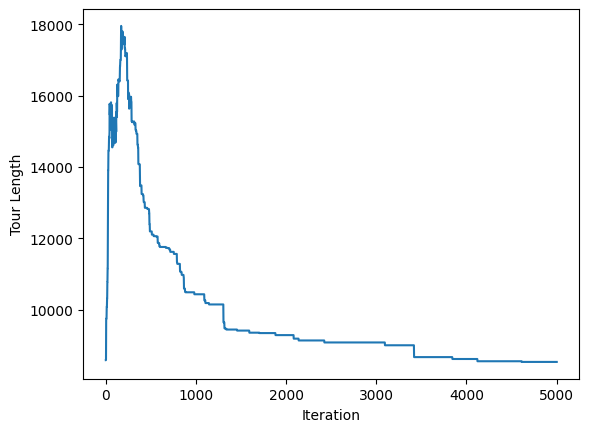

In [310]:
#plot tour_length_logs
import matplotlib.pyplot as plt
plt.plot(tour_length_logs)
plt.ylabel('Tour Length')
plt.xlabel('Iteration')
plt.show()

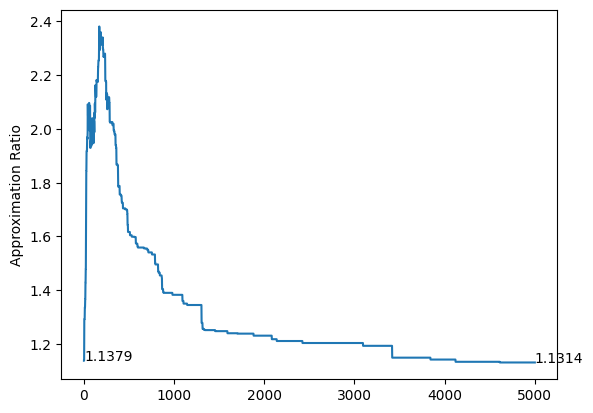

In [313]:
# plot apx_ratio_logs
plt.plot(apx_ratio_logs)
plt.ylabel('Approximation Ratio')
# annotate first and last point
plt.annotate(f"{apx_ratio_logs[0]:.4f}", (0, apx_ratio_logs[0]))
# annotate last point
plt.annotate(f"{apx_ratio_logs[-1]:.4f}", (len(apx_ratio_logs) - 1, apx_ratio_logs[-1]))
plt.show()

In [314]:
temp_logs = []
for temp in range(500, 10001):
    for name in tsp_dataset["name"]:
        if name != "berlin52":
            continue
        print(name)

        G = get_tsp_graph(name)
        dimension = G.number_of_nodes()
        opt_tour_length = get_opt_tour_length(name)

        d = {
            "name": name,
            "dimension": dimension,
            "opt_tour_length": opt_tour_length,
        }

        best_tour = None
        best_tour_length = None
        best_tour_k = None

        best_sa_tour = None
        best_sa_tour_length = None
        best_sa_tour_k = None

        c_tour = None
        c_tour_length = None

        start_time = time.time()

        for k in range(1, 2):
            print(name, k)
            tree = st.get_mst_k(G, k)
            tour = christofides(G, tree=tree)
            tour_length = get_tour_length(G, tour)

            if k == 1:
                c_tour = tour
                c_tour_length = tour_length

            if best_tour is None or tour_length < best_tour_length:
                best_tour = tour
                best_tour_length = tour_length
                best_tour_k = k

            sa = SimulateAnnealing(
                graph=G,
                initial_solution=tour,
                max_iterations=5000,
                initial_temperature=temp,
                cooling_rate=0.01,
            )
            sa_tour, sa_tour_cost = sa.run()
            sa_tour_length = get_tour_length(G, sa_tour)
            assert sa_tour_cost == sa_tour_length

            if best_sa_tour is None or sa_tour_length < best_sa_tour_length:
                best_sa_tour = sa_tour
                best_sa_tour_length = sa_tour_length
                best_sa_tour_k = k

        end_time = time.time()
        elapsed_time = end_time - start_time

        c_apx_ratio = c_tour_length / opt_tour_length
        best_apx_ratio = best_tour_length / opt_tour_length
        best_sa_apx_ratio = best_sa_tour_length / opt_tour_length

        d["c_tour_length"] = c_tour_length
        d["best_tour_length"] = best_tour_length
        d["best_sa_tour_length"] = best_sa_tour_length
        d["c_apx_ratio"] = c_apx_ratio
        d["best_apx_ratio"] = best_apx_ratio
        d["best_sa_apx_ratio"] = best_sa_apx_ratio
        d["best_tour_k"] = best_tour_k
        d["best_sa_tour_k"] = best_sa_tour_k
        d["elapsed_time"] = elapsed_time

        print(list(d.values()))
        
        temp_logs.append((temp, best_sa_tour_length))

        print()

berlin52
berlin52 1
['berlin52', 52, 7542, 8582, 8582, 8325, 1.1378944577035268, 1.1378944577035268, 1.10381861575179, 1, 1, 0.6142899990081787]

berlin52
berlin52 1
['berlin52', 52, 7542, 8582, 8582, 8049, 1.1378944577035268, 1.1378944577035268, 1.0672235481304693, 1, 1, 0.551382303237915]

berlin52
berlin52 1
['berlin52', 52, 7542, 8582, 8582, 8362, 1.1378944577035268, 1.1378944577035268, 1.1087244762662425, 1, 1, 0.6092753410339355]

berlin52
berlin52 1
['berlin52', 52, 7542, 8582, 8582, 8582, 1.1378944577035268, 1.1378944577035268, 1.1378944577035268, 1, 1, 0.5573055744171143]

berlin52
berlin52 1
['berlin52', 52, 7542, 8582, 8582, 8314, 1.1378944577035268, 1.1378944577035268, 1.1023601166799257, 1, 1, 0.6132748126983643]

berlin52
berlin52 1
['berlin52', 52, 7542, 8582, 8582, 8582, 1.1378944577035268, 1.1378944577035268, 1.1378944577035268, 1, 1, 0.4814455509185791]

berlin52
berlin52 1
['berlin52', 52, 7542, 8582, 8582, 8409, 1.1378944577035268, 1.1378944577035268, 1.114956245027

In [315]:
# write temp_logs to csv
with open("sa_temp_logs_berlin52.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["temp", "best_sa_tour_length"])
    for temp, best_sa_tour_length in temp_logs:
        writer.writerow([temp, best_sa_tour_length])
        csvfile.flush()